
# Localización de un robot en una cuadrícula usando Modelos Ocultos de Markov (HMM)

**Contenido:** Localization, Transition Model, Sensor Model, Filtering, Visualize (posterior como círculos), Smoothing (forward-backward), Viterbi (secuencia más probable).  


### Título
**Localización probabilística de un robot en ambiente estático (HMM)**

### Problematización
En este proyecto buscamos resolver un problema clásico de localización en robótica:
un robot se mueve dentro de un ambiente representado como una cuadrícula, pero no sabe exactamente en qué posición se encuentra.

El robot solo puede moverse a casillas libres (no ocupadas por obstáculos) y, en cada paso, se desplaza a una casilla adyacente con la misma probabilidad. Sin acceso directo a su ubicación real, el robot solo dispone de **cuatro sensores** (Norte, Sur, Este, Oeste) que informan la presencia de un obstáculo en cada dirección, pero estos sensores fallan con probabilidad ε (error independiente por sensor).

**Problema central:** ¿Cómo inferir la probabilidad de estar en cada casilla (o la secuencia más probable de posiciones) dado el modelo de movimiento y las observaciones ruidosas recibidas por los sensores?

### Enfoque
Usamos un **Modelo Oculto de Markov** con:
- Estados: las casillas libres de la cuadrícula.
- Transición: movimiento uniforme a casillas adyacentes libres.
- Observación: lectura binaria (obstáculo / libre) en N,E,S,W con error ε por sensor.

Aplicamos algoritmos estándar de HMM:
- **Filtering (Forward):** calcular la distribución de creencias en tiempo t dado observaciones hasta t.
- **Viterbi:** encontrar la secuencia de estados más probable dada la secuencia de observaciones.
- Visualizaciones de la distribución de probabilidad sobre la cuadrícula y comparativa con la verdad simulada.

### Propósito
Entregar una solución reproducible y bien documentada que:
- Explique la modelación HMM del problema.
- Implemente y demuestre algoritmos de inferencia (filtering y Viterbi).
- Visualice resultados y discuta conclusiones sobre robustez frente al ruido.

### Información
- Entrada: mapa en cuadrícula (ocupado/libre), sensor error ε, secuencia de observaciones (4 bits por paso).
- Salida: creencias (distribución sobre posiciones) por paso, predicción Viterbi de la trayectoria, métricas de desempeño.

### Razonamiento
- Construir espacio de estados usando casillas libres.
- Calcular matriz de transición basada en adyacencia.
- Definir función de probabilidad de observación basada en discrepancia Hamming entre lectura y la realidad del entorno alrededor de cada casilla.
- Aplicar algoritmos HMM y normalizar para obtener distribuciones válidas.
- Visualizar mapas de creencias y comparar con la posición real simulada para validar comportamiento.



In [1]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import colors
from collections import defaultdict
%matplotlib inline


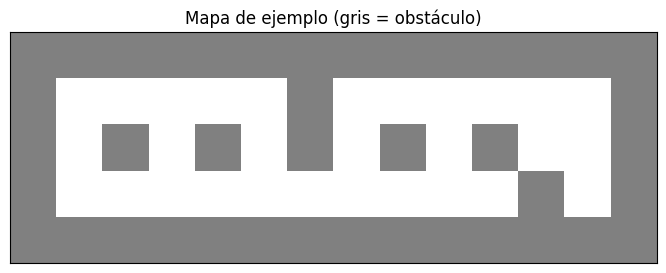

In [2]:

# Define a wider example map (0=free, 1=obstacle), rectangular like the reference image
example_map = np.array([
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [1,0,0,0,0,0,1,0,0,0,0,0,0,1],
    [1,0,1,0,1,0,1,0,1,0,1,0,0,1],
    [1,0,0,0,0,0,0,0,0,0,0,1,0,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
])
h, w = example_map.shape
plt.figure(figsize=(10,3))
plt.imshow(example_map, cmap=colors.ListedColormap(['white','gray']), origin='upper')
plt.title('Mapa de ejemplo (gris = obstáculo)')
plt.xticks([]); plt.yticks([])
plt.show()


In [3]:

# List free cells and mappings
def free_cells(grid):
    free = []
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if grid[i,j] == 0:
                free.append((i,j))
    return free

states = free_cells(example_map)
n_states = len(states)
state_to_idx = {s:i for i,s in enumerate(states)}
idx_to_state = {i:s for i,s in enumerate(states)}
print("Número de estados (casillas libres):", n_states)

def neighbors(cell, grid):
    i,j = cell
    cand = [(i-1,j),(i+1,j),(i,j-1),(i,j+1)]
    valid = [c for c in cand if 0 <= c[0] < grid.shape[0] and 0 <= c[1] < grid.shape[1] and grid[c]==0]
    return valid

# Transition matrix: uniform over free adjacent cells (as described)
P = np.zeros((n_states, n_states))
for i, s in enumerate(states):
    neigh = neighbors(s, example_map)
    if len(neigh) == 0:
        P[i,i] = 1.0
    else:
        for nb_cell in neigh:
            j = state_to_idx[nb_cell]
            P[i,j] = 1.0/len(neigh)
# sanity
print("Filas suman (min,max):", P.sum(axis=1).min(), P.sum(axis=1).max())


Número de estados (casillas libres): 29
Filas suman (min,max): 1.0 1.0


In [4]:

# Sensor model: 4-bit (N,E,S,W) with independent flip probability epsilon
def true_observation_for_cell(cell, grid):
    i,j = cell
    dirs = [(-1,0),(0,1),(1,0),(0,-1)]  # N,E,S,W
    obs = []
    for di,dj in dirs:
        ni,nj = i+di, j+dj
        if ni<0 or ni>=grid.shape[0] or nj<0 or nj>=grid.shape[1]:
            obs.append(1)  # wall -> obstacle
        else:
            obs.append(1 if grid[ni,nj]==1 else 0)
    return tuple(obs)

true_obs = {s: true_observation_for_cell(s, example_map) for s in states}

def observation_likelihood(o, s, epsilon):
    true = true_obs[s]
    d = sum(int(a!=b) for a,b in zip(o,true))
    return (epsilon**d) * ((1-epsilon)**(4-d))

# Show a few true observations for reference
for s in states[:8]:
    print(s, "->", true_obs[s])


(1, 1) -> (1, 0, 0, 1)
(1, 2) -> (1, 0, 1, 0)
(1, 3) -> (1, 0, 0, 0)
(1, 4) -> (1, 0, 1, 0)
(1, 5) -> (1, 1, 0, 0)
(1, 7) -> (1, 0, 0, 1)
(1, 8) -> (1, 0, 1, 0)
(1, 9) -> (1, 0, 0, 0)


In [5]:

import random
random.seed(0)
np.random.seed(0)

def simulate_trajectory(start_state, P, steps=5):
    path = [start_state]
    cur = start_state
    for _ in range(steps-1):
        probs = P[state_to_idx[cur]]
        j = np.random.choice(range(len(probs)), p=probs)
        cur = idx_to_state[j]
        path.append(cur)
    return path

def noisy_observations(path, epsilon):
    obs_seq = []
    for s in path:
        true = true_obs[s]
        noisy = []
        for bit in true:
            if np.random.rand() < epsilon:
                noisy.append(1-bit)
            else:
                noisy.append(bit)
        obs_seq.append(tuple(noisy))
    return obs_seq

# choose a starting state roughly near left top free cell
start = states[0]
true_path = simulate_trajectory(start, P, steps=4)
epsilon = 0.15
obs_seq = noisy_observations(true_path, epsilon)
print("True short path:", true_path)
print("Observations (noisy):", obs_seq)


True short path: [(1, 1), (2, 1), (3, 1), (3, 2)]
Observations (noisy): [(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 0), (0, 1, 1, 0)]


In [6]:

def plot_posterior_circles(belief, grid, title='', ax=None, fill_threshold=0.6):
    # belief: vector over states (not necessarily normalized)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,3))
    # plot grid background: obstacles in gray, free in white with grid lines
    h,w = grid.shape
    ax.set_xlim(-0.5, w-0.5)
    ax.set_ylim(h-0.5, -0.5)
    # draw cells
    for i in range(h):
        for j in range(w):
            rect = patches.Rectangle((j-0.5,i-0.5),1,1, linewidth=1, edgecolor='black',
                                     facecolor='lightgray' if grid[i,j]==1 else 'white')
            ax.add_patch(rect)
    # normalize belief for sizing
    b = np.array(belief, dtype=float)
    if b.sum() > 0:
        b = b / b.sum()
    # map states to sizes
    # sizes scaled: smallest 50, largest 1200 (visual)
    min_size, max_size = 40, 1400
    if len(b)>0 and b.max() > 0:
        sizes = min_size + (max_size - min_size) * (b - b.min()) / (b.max() - b.min() + 1e-12)
    else:
        sizes = np.full_like(b, min_size)
    # draw circles at centers of free cells
    for idx, prob in enumerate(b):
        (i,j) = idx_to_state[idx]
        s = sizes[idx]
        # filled large black circle for top probabilities, empty circle for lower ones (mimic figure)
        if prob >= (b.max() * fill_threshold):
            circ = patches.Circle((j, i), radius=0.3 + 0.003*np.sqrt(s), facecolor='black', edgecolor='black', linewidth=1.2)
            ax.add_patch(circ)
            # add small white dot inside like figure's bullseye for highest probs
            inner = patches.Circle((j,i), radius=0.08, facecolor='white', edgecolor='none')
            ax.add_patch(inner)
        else:
            circ = patches.Circle((j, i), radius=0.25 + 0.0025*np.sqrt(s), facecolor='none', edgecolor='black', linewidth=1)
            ax.add_patch(circ)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


Belief sums (per t): [1. 1. 1. 1.]


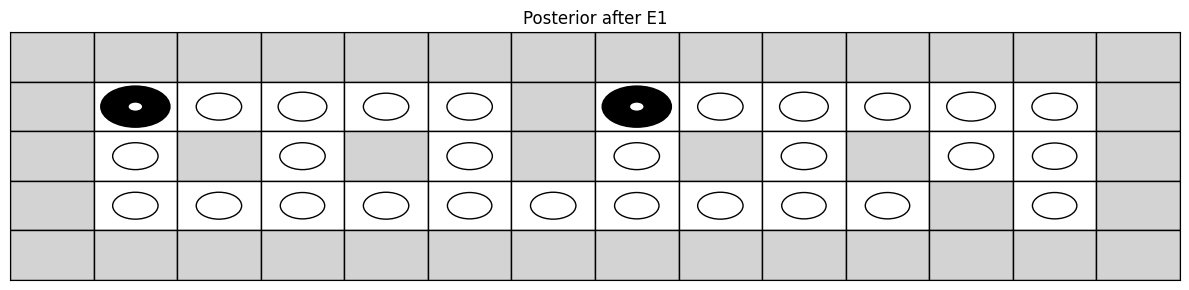

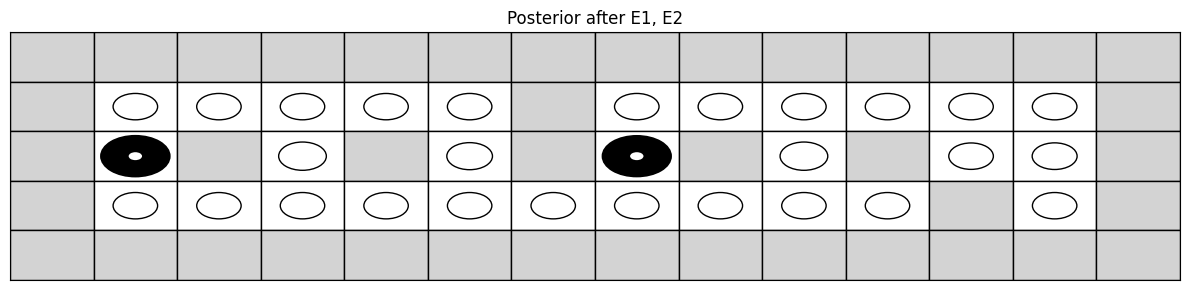

In [7]:

def normalize(vec):
    s = np.sum(vec)
    if s == 0:
        return np.ones_like(vec)/len(vec)
    return vec / s

def forward_filter(P, obs_seq, epsilon, prior=None):
    T = len(obs_seq)
    n = P.shape[0]
    if prior is None:
        prior = np.ones(n)/n
    alphas = np.zeros((T,n))
    # t=0
    for i in range(n):
        alphas[0,i] = prior[i] * observation_likelihood(obs_seq[0], idx_to_state[i], epsilon)
    alphas[0] = normalize(alphas[0])
    for t in range(1,T):
        for j in range(n):
            alphas[t,j] = observation_likelihood(obs_seq[t], idx_to_state[j], epsilon) * np.sum(alphas[t-1,:] * P[:,j])
        alphas[t] = normalize(alphas[t])
    return alphas

alphas = forward_filter(P, obs_seq, epsilon)
print('Belief sums (per t):', alphas.sum(axis=1))
# Plot posterior after E1 and after E1,E2 to mirror the example figure
plot_posterior_circles(alphas[0], example_map, title='Posterior after E1')
if alphas.shape[0] > 1:
    plot_posterior_circles(alphas[1], example_map, title='Posterior after E1, E2')


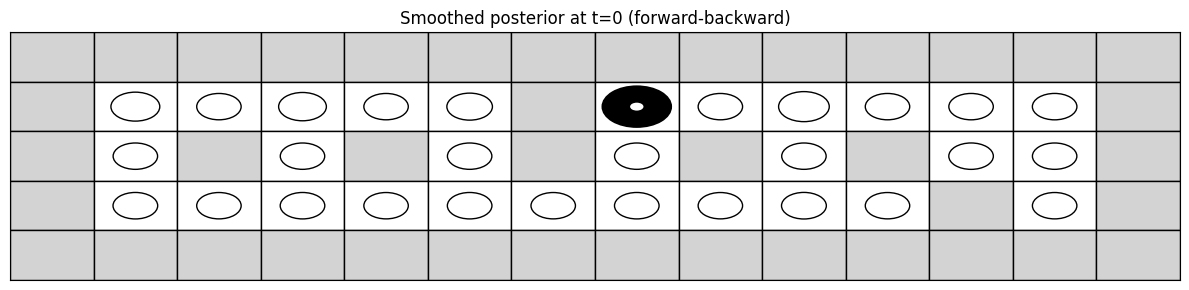

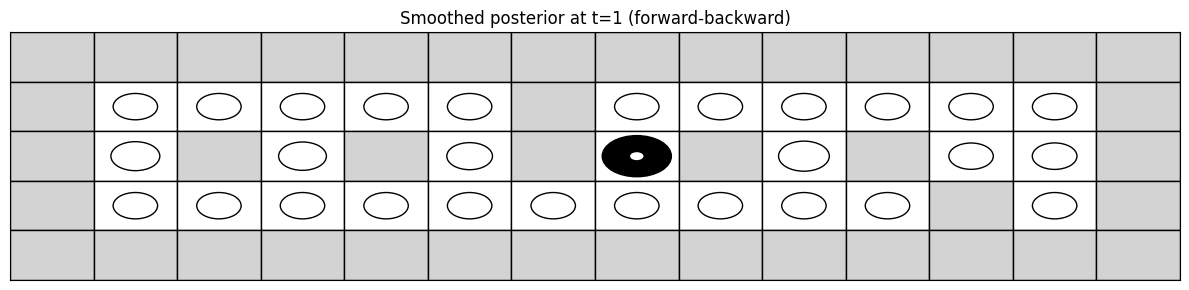

In [8]:

def backward(P, obs_seq, epsilon):
    T = len(obs_seq)
    n = P.shape[0]
    betas = np.zeros((T,n))
    betas[T-1,:] = 1.0
    for t in range(T-2, -1, -1):
        for i in range(n):
            betas[t,i] = np.sum(P[i,:] * [observation_likelihood(obs_seq[t+1], idx_to_state[j], epsilon) * betas[t+1,j] for j in range(n)])
        betas[t] = normalize(betas[t])
    return betas

def smooth(P, obs_seq, epsilon, prior=None):
    alphas = forward_filter(P, obs_seq, epsilon, prior)
    betas = backward(P, obs_seq, epsilon)
    smoothed = np.zeros_like(alphas)
    for t in range(len(obs_seq)):
        smoothed[t] = normalize(alphas[t] * betas[t])
    return smoothed, alphas, betas

smoothed, alphas, betas = smooth(P, obs_seq, epsilon)
# show smoothing result for t=0 and t=1
plot_posterior_circles(smoothed[0], example_map, title='Smoothed posterior at t=0 (forward-backward)')
if smoothed.shape[0] > 1:
    plot_posterior_circles(smoothed[1], example_map, title='Smoothed posterior at t=1 (forward-backward)')


Viterbi path: [(1, 7), (2, 7), (3, 7), (2, 7)]


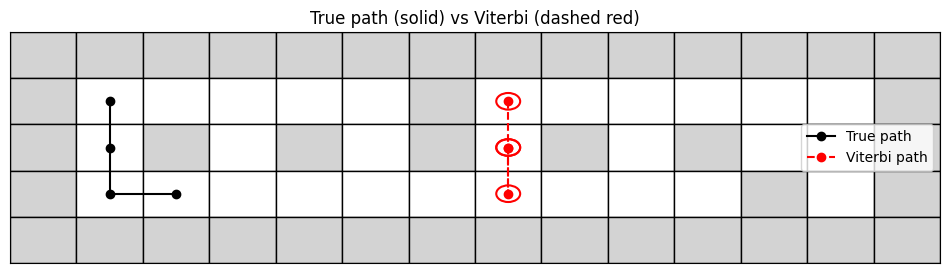

In [9]:

def viterbi(P, obs_seq, epsilon, prior=None):
    T = len(obs_seq); n = P.shape[0]
    if prior is None:
        prior = np.ones(n)/n
    logP = np.log(P + 1e-12)
    log_prior = np.log(prior + 1e-12)
    V = np.full((T,n), -np.inf)
    bp = np.zeros((T,n), dtype=int)
    # init
    for i in range(n):
        V[0,i] = log_prior[i] + np.log(observation_likelihood(obs_seq[0], idx_to_state[i], epsilon) + 1e-12)
    for t in range(1,T):
        for j in range(n):
            vals = V[t-1,:] + logP[:,j]
            k = np.argmax(vals)
            V[t,j] = vals[k] + np.log(observation_likelihood(obs_seq[t], idx_to_state[j], epsilon) + 1e-12)
            bp[t,j] = k
    path_idx = [0]*T
    path_idx[-1] = np.argmax(V[-1,:])
    for t in range(T-2, -1, -1):
        path_idx[t] = bp[t+1, path_idx[t+1]]
    return [idx_to_state[i] for i in path_idx]

v_path = viterbi(P, obs_seq, epsilon)
print('Viterbi path:', v_path)

# plot both true path and viterbi with markers (true=filled circle with white dot, viterbi=ring)
def plot_paths_overlay(true_path, v_path, grid):
    fig, ax = plt.subplots(figsize=(12,3))
    # draw grid
    h,w = grid.shape
    ax.set_xlim(-0.5, w-0.5); ax.set_ylim(h-0.5, -0.5)
    for i in range(h):
        for j in range(w):
            rect = patches.Rectangle((j-0.5,i-0.5),1,1, linewidth=1, edgecolor='black',
                                     facecolor='lightgray' if grid[i,j]==1 else 'white')
            ax.add_patch(rect)
    # true path
    tp = np.array(true_path)
    vp = np.array(v_path)
    if len(tp)>0:
        ax.plot(tp[:,1], tp[:,0], marker='o', linestyle='-', color='black', label='True path')
        # inner white dot
        for (r,c) in tp:
            ax.add_patch(patches.Circle((c,r), radius=0.12, facecolor='white', edgecolor='none'))
    if len(vp)>0:
        ax.plot(vp[:,1], vp[:,0], marker='o', linestyle='--', color='red', label='Viterbi path')
        for (r,c) in vp:
            circ = patches.Circle((c,r), radius=0.18, facecolor='none', edgecolor='red', linewidth=1.5)
            ax.add_patch(circ)
    ax.set_title('True path (solid) vs Viterbi (dashed red)')
    ax.set_xticks([]); ax.set_yticks([])
    ax.legend()
    plt.show()

plot_paths_overlay(true_path, v_path, example_map)


**CONCLUSIONES**


La implementación del modelo oculto de Markov permitió analizar de manera rigurosa cómo un robot puede estimar su posición en un ambiente parcialmente observable y con sensores inherentemente ruidosos. A lo largo del desarrollo del filtro hacia adelante (filtering), del algoritmo de suavizamiento (forward–backward) y del algoritmo de Viterbi, se pudo constatar que los HMM constituyen un marco matemático robusto para la localización probabilística.

En primer lugar, se observó que el proceso de filtrado actualiza de forma incremental la creencia sobre la posición del robot conforme llegan nuevas observaciones, integrando la incertidumbre tanto del modelo de movimiento como del error sensorial. Esto es particularmente relevante en robótica móvil, ya que, aun cuando el robot desconoce su estado real, el HMM es capaz de mantener una distribución de probabilidad coherente con el historial de evidencia.

Por otro lado, el suavizamiento (smoothing) mostró un aspecto importante: disponer de observaciones futuras reduce significativamente la incertidumbre sobre los estados pasados. Este resultado evidencia que los HMM no solo son herramientas de predicción en línea, sino también de reconstrucción histórica, permitiendo entender en qué punto del entorno es más probable que el robot haya estado, incluso cuando algunas observaciones iniciales eran ambiguas o incorrectas.

El algoritmo de Viterbi, centrado en encontrar la secuencia más probable de estados, demostró ser especialmente útil cuando se desea obtener un camino determinista. No obstante, también se apreció que su desempeño depende fuertemente de la calidad del sensor: conforme aumenta el valor de ε, la secuencia estimada puede divergir rápidamente del movimiento real del robot, reflejando cómo el ruido sensorial puede inducir errores acumulativos.

- El HMM (modelo de transición + modelo de observación ruidoso) permite al robot mantener una **distribución de creencias** sobre su posición que se actualiza conforme llegan observaciones.
- El **algoritmo Forward (filtering)** calcula de forma recursiva la creencia filtrada \(P(X_t \mid o_{1:t})\).
- El **algoritmo Viterbi** proporciona la secuencia de estados más probable dada la secuencia completa de observaciones.
- A mayor tasa de error de sensor (ε) aumenta la incertidumbre (entropía) y suele reducir la precisión de Viterbi.
- Puedes experimentar cambiando el mapa, ε, y la longitud de la secuencia para estudiar robustez.
